<a href="https://colab.research.google.com/github/aml-spring-19/homework-5-cv5/blob/master/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import keras

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# processing & model selection
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit

# models
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Input, add, Conv2D, MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

# other
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# task3 data loading
import fnmatch
from glob2 import glob
import cv2

Using TensorFlow backend.


# Exploring neural networks

## 1. Classification with the iris dataset

The first task is to run a multilayer perceptron with two hidden layers and relu activations, using the Keras Sequential Interface. We also tune for regularization strength and number of hidden units. 

Importing the data:

In [0]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Map the target variable:

In [0]:
print(df.species.unique())

['setosa' 'versicolor' 'virginica']


In [0]:
mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
df.species.replace(mapping, inplace = True)

Split our dataset into training and test sets. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('species', axis=1), df.species, test_size=0.2)

Encode the target:

In [0]:
num_species = len(df['species'].unique())

y_train = to_categorical(y_train, num_species)
y_test = to_categorical(y_test, num_species)

Make our model:

In [0]:
X_train.shape

(120, 4)

In [0]:
def make_model(hidden_size, reg_strength, optimizer='adam'):
    """
    Create the model to pass to the Keras Classifier
    """
    
    model = Sequential([
        Dense(hidden_size, input_shape=(4,), activation='relu',   # first layer
              kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(hidden_size, activation='relu',                     # second layer
              kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(3, activation='softmax')                            # output layer
    ])
    
    # compile the above model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Before proceeding any further, we should initialize the cross-validation method to be used in the grid search later on. 

In [0]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [0]:
clf = KerasClassifier(make_model, epochs=10, verbose=0)

param_grid = {'hidden_size': [32, 64, 128],
              'reg_strength': np.logspace(-3, -1, 5)}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1)
grid.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc5af1445c0>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_size': [32, 64, 128], 'reg_strength': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print('Best score: {}'.format(np.round(grid.best_score_, 2)))
print('Best params: {}'.format(grid.best_params_))

Best score: 0.92
Best params: {'hidden_size': 128, 'reg_strength': 0.001}


In [0]:
score = grid.score(X_test, y_test)
print('Test score: {}'.format(np.round(score, 2)))

Test score: 0.97


## 2. Classification with the MNIST fashion dataset

We will train a multilayer perceptron (fully connected) on the Fashion MNIST dataset. 
We'll first use 10000 samples from the training set for model selection and to compute learning curves (accuracy vs epochs).
Then, we'll compare the following models and plot their learning curves:
    - Vanilla Model
    - Model using dropout
    - Model using batch normalization and residual connections (but no dropout)





In [0]:
# loading the data
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 1us/step


In [0]:
print('Training size: {}, Test size: {}'.format(X_train.shape[0],X_test.shape[0]))
print('Each image has a shape of: {}x{}'.format(X_train.shape[1], X_train.shape[2]))

Training size: 60000, Test size: 10000
Each image has a shape of: 28x28


Before proceeding with the modeling, we have to process our data accordingly. 

In [0]:
# reshape X and cast to float
X_train = X_train.reshape(60000, 784); X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32'); X_test = X_test.astype('float32')

# scale X
X_train /= 255; X_test /= 255

# encode the target accordingly
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes); y_test = to_categorical(y_test, n_classes)

We also have to get a stratified sample of size 10000 from the training set for model selection.

In [0]:
X, X_valid, y, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=6)

In [0]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=1/6, random_state=6)
# for a, b in sss.split(X_train, y_train):
#     X_sample, y_sample = X_train[b], y_train[b]

### Parameter Tuning

In [0]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=410)

**Vanilla Model**

We start off by tuning our vanilla model. Vanilla models are typically used to describe simple networks with 1 layer, so we'll only look at optimizing the number of hidden units in this case. 

In [0]:
def make_model(hidden_size):
    """
    Create the model to pass to the Keras Classifier
    """
    
    model = Sequential([
        Dense(hidden_size, input_shape=(784,), activation='relu'), # first layer
        Dense(10, activation='softmax')                            # output layer
    ])
    
    # compile the above model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [0]:
clf = KerasClassifier(make_model, epochs=10, verbose=0)

param_grid = {'hidden_size': [256, 512]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1).fit(X, y)

In [0]:
print('VANILLA MODEL TUNING:')
print('Best Score: {}'.format(np.round(grid.best_score_, 2)))
print('Best Hidden Size: {}'.format(grid.best_params_['hidden_size']))

VANILLA MODEL TUNING:
Best Score: 0.88
Best Hidden Size: 512


In [0]:
vanilla = grid.best_estimator_
history_vanilla = vanilla.fit(X, y, epochs=10, validation_data=(X_valid, y_valid))

**Bigger Model w/ Dropout**

We can now proceed with tuning our bigger model with dropout. 

In [0]:
def make_model(hidden_size, hidden_layers, dp_p):
    """
    Create the model to pass to the Keras Classifier
    """
    model = Sequential()
    
    # input layer
    model.add(Dense(hidden_size, input_shape=(784,), activation='relu'))
    model.add(Dropout(dp_p))
    
    # add as many layers as needed
    for i in range(hidden_layers):
        model.add(Dense(hidden_size, activation='relu')) 
        model.add(Dropout(dp_p))  
    
    # output layer
    model.add(Dense(10, activation='softmax'))
    
    
    # compile the above model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [0]:
clf = KerasClassifier(make_model, epochs=10, verbose=0)

param_grid = {'hidden_size': [256, 512],
              'hidden_layers': [1,2,3],
              'dp_p': np.linspace(0.25, 0.75, 3)}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1).fit(X, y)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
print('DROPOUT MODEL TUNING:')
print('Best Score: {}'.format(np.round(grid.best_score_, 2)))
print('Best Hidden Size: {}'.format(grid.best_params_['hidden_size']))
print('Best Number of Hidden Layers: {}'.format(grid.best_params_['hidden_layers']))
print('Best Dropout Prob: {}'.format(grid.best_params_['dp_p']))

DROPOUT MODEL TUNING:
Best Score: 0.88
Best Hidden Size: 512
Best Number of Hidden Layers: 1
Best Dropout Prob: 0.25


In [0]:
dropout = grid.best_estimator_
history_dropout = dropout.fit(X, y, epochs=10, validation_data=(X_valid, y_valid))

**Residual Batch Model**

Moving on to our final model for this task - we introduce batch normalization and residual connections. 

In [0]:
inputs = Input(shape=(784,))                 # input

x1 = Dense(256, activation='relu')(inputs)   # first layer: 256 units

x2 = Dense(256, activation='relu')(x1)       # second layer: 256 units
x2 = BatchNormalization()(x2)                # batch normalization
x2 = add([x1, x2])                           # residual connection

x3 = Dense(256, activation='relu')(x2)       # third layer: 256 units
x3 = BatchNormalization()(x3)                # batch normalization
x3 = add([x2, x3])                           # residual connection 

x4 = Dense(128, activation='relu')(x3)       # fourth layer: 128 units
x4 = BatchNormalization()(x4)                # batch normalization

preds = Dense(10, activation='softmax')(x4)

resbatch = Model(inputs=inputs, outputs=preds)

In [0]:
resbatch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resbatch = resbatch.fit(X, y, epochs=10, validation_data=(X_valid, y_valid), verbose=0)

In [0]:
for k, h in {'vanilla': history_vanilla,
             'dropout': history_dropout,
             'resbatch': history_resbatch}.items():
    print(k.upper() + ' RESULTS:')
    print('Training Accuracy: {}'.format(np.round(h.history['acc'][-1], 2)))
    print('Validation Accuracy: {}'.format(np.round(h.history['val_acc'][-1], 2)))

VANILLA RESULTS:
Training Accuracy: 0.91
Validation Accuracy: 0.9
DROPOUT RESULTS:
Training Accuracy: 0.89
Validation Accuracy: 0.89
RESBATCH RESULTS:
Training Accuracy: 0.9
Validation Accuracy: 0.89


### Learning Curves

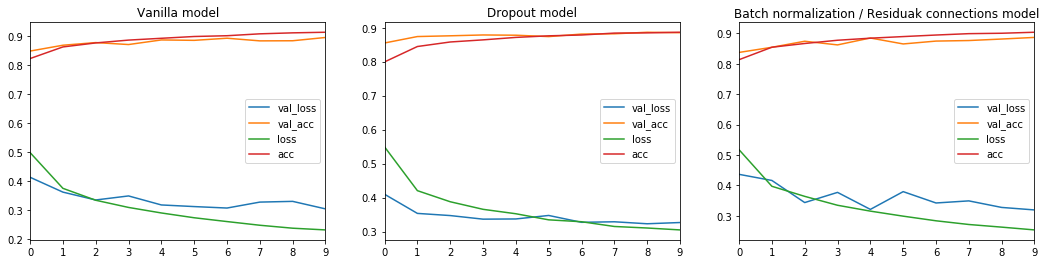

In [0]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))
pd.DataFrame(history_vanilla.history).plot(ax=ax[0])
ax[0].set_title("Vanilla model")
pd.DataFrame(history_dropout.history).plot(ax=ax[1])
ax[1].set_title("Dropout model")
pd.DataFrame(history_resbatch.history).plot(ax=ax[2])
ax[2].set_title("Batch normalization / Residuak connections model")
plt.show()

## 3. Classifying breast histopathology images

Before proceeding, we should get the data. We have downloaded the dataset onto a Google Drive, where we can unzip the file and load the images.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# unzip the new zip file and store all its files into our images directory
!unzip -q -o drive/'My Drive'/'histopathology'/IDC_regular_ps50_idx5.zip -d images

In [0]:
# load the images
imagePatches = glob('images/**/*.png', recursive=True)

# seperate our two classes
class0 = fnmatch.filter(imagePatches, '*class0.png')
class1 = fnmatch.filter(imagePatches, '*class1.png')

# create our target variable
y = []
for img in imagePatches:
    if img in class0:
        y.append(0)
    elif img in class1:
        y.append(1)

We turn the images and the target into a dataframe so we can see the class proportions and create a test set. 

In [0]:
images_df = pd.DataFrame()
images_df['images'] = imagePatches
images_df['y'] = y

In [0]:
images_df.groupby('y').size()

y
0    198738
1     78786
dtype: int64

Given the imbalanced proportions of our dataset, we implement downsampling.

In [0]:
images_0 = images_df[images_df.y == 0]  # all our images w/ class 0
images_1 = images_df[images_df.y == 1]  # all our images w/ class 1

# downsample the majority class (0)
images_0 = resample(images_0, replace=False, n_samples=images_1.shape[0], random_state=42)
# images_1 = resample(images_1, replace=False, n_samples=100000, random_state=42)

df = pd.concat([images_0, images_1])    # join the two back together

In [0]:
df.head(3)

,images,y
21948,images/10268/0/10268_idx5_x3501_y1101_class0.png,0
83757,images/14211/0/14211_idx5_x701_y2101_class0.png,0
181091,images/13616/0/13616_idx5_x1551_y701_class0.png,0


In [0]:
df = df.sample(frac=1).reset_index(drop=True)


We can now process our images:

In [0]:
y = df.y
X = np.asarray([cv2.resize(cv2.imread(img), (50,50)) for img in df.images])

We create a test set and encode/process our data accordingly:

In [0]:
# encode the target accordingly
n_classes = len(np.unique(y))                  # number of classes in our target
y = to_categorical(y, n_classes)               # encode training

# cast X to float and scale
X = X.astype('float32')
X /= 255

Now that our data is ready, we can proceed with our tasks. 

**3.1**: A model without residual connections.

**3.2**: Augment the data. How much has this improved the original model?

**3.3**: Build a deeper model using residual connections. Show that you can build a deep model that would not be able to learn without the residual connections.

#### 3.1 Simple Model

In [0]:
input_shape = (50, 50, 3)
simple = Sequential()

                                                             ### Layer 1 ###
simple.add(Conv2D(32, (2, 2), activation='relu',             # Convolutional L
                  input_shape=input_shape))
simple.add(BatchNormalization())                             # Batch Norm.
simple.add(MaxPooling2D(pool_size=(2, 2)))                   # Pooling Layer

                                                             ### Layer 2 ###
simple.add(Conv2D(32, (2, 2), activation='relu'))            # Conv. Layer
simple.add(BatchNormalization())                             # Batch Norm.
simple.add(MaxPooling2D(pool_size=(2, 2)))                   # Pooling Layer

                                                             ### Layer 3 ###
simple.add(Flatten())                                        # Flatten the data
simple.add(Dense(128, activation='relu'))                    # 64 units dense

simple.add(Dense(2, activation='softmax'))                   ### Output ###

simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
history_simple = simple.fit(X, y, batch_size=128, epochs=10, verbose=1,
                            validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 141814 samples, validate on 15758 samples
Epoch 1/10
141814/141814 [==============================] - 21s 145us/step - loss: 0.4027 - acc: 0.8292 - val_loss: 0.5967 - val_acc: 0.7365
Epoch 2/10
141814/141814 [==============================] - 17s 121us/step - loss: 0.3528 - acc: 0.8502 - val_loss: 1.2139 - val_acc: 0.6669
Epoch 3/10
141814/141814 [==============================] - 17s 121us/step - loss: 0.3371 - acc: 0.8576 - val_loss: 0.6629 - val_acc: 0.7253
Epoch 4/10
141814/141814 [==============================] - 18s 124us/step - loss: 0.3245 - acc: 0.8627 - val_loss: 0.3839 - val_acc: 0.8470
Epoch 5/10
141814/141814 [==============================] - 17s 121us/step - loss: 0.3112 - acc: 0.8694 - val_loss: 0.6542 - val_acc: 0.7390
Epoch 6/10
141814/141814 [==============================] - 17s 122us/step - loss: 0.2958 - acc: 0.8767 - val_loss: 1.3702 - val_acc: 0.6005
Epoch 7/10
141814/141814 [=============================

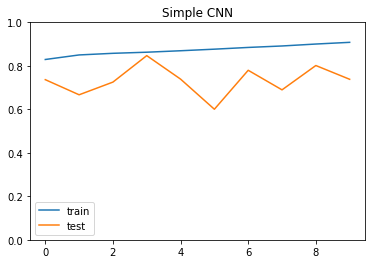

In [0]:
plt.plot(history_simple.history['acc'], label='train')
plt.plot(history_simple.history['val_acc'], label='test')
plt.title("Simple CNN")
plt.legend()
plt.ylim(0,1)
plt.show()

In [0]:
print('Training Accuracy: {}'.format(np.round(history_simple.history['acc'][-1], 2)))
print('Validation Accuracy: {}'.format(np.round(history_simple.history['val_acc'][-1], 2)))

Training Accuracy: 0.91
Validation Accuracy: 0.74


As we can see, our model has a good training accuracy, but appears to overfit a little. The validation accuracy in particular fluctuates a lot.

#### 3.2 Augmenting the data

We're now going to try data augmentation to improve the results of the same CNN - this technique will likely lead our network to overfit less. Here are the options we have: 

- Mirroring
- Rotations
- Translations
- Scaling (zooming in/out)

When taking a look at the data, it makes sense to apply all these transformations to the images we have, since they don't have a "normalized" size, orientation, etc. If we were working on the digits dataset, it wouldn't make sense to apply rotations for instance, but here we don't have that problem and we can apply pretty much what we want, since a quick look at the images tells us that they don't seem to be standardized in their scale, orientation, centering, etc.

We're going to do what's called "online" data augmentation, i.e. data augmentation "on the fly", whenever we train a batch. Otherwise, the dataset we'd create would be way too large. 



In [0]:
data_aug = image.ImageDataGenerator(
      horizontal_flip=True,                       ## Mirroring (horizontal)
      vertical_flip=True,                         ## Mirroring (vertical)
      rotation_range=90,                          ## Rotation
      width_shift_range=0.2,                      ## Translation (horizontal)
      height_shift_range=0.2,                     ## Translation (vertical)
      zoom_range=[1,2],                           ## Zooming in
      validation_split=0.1
      )

train_generator = data_aug.flow(X, y, batch_size=128, subset='training')
val_generator = data_aug.flow(X, y, batch_size=128, subset='validation')

history_aug = simple.fit_generator(train_generator, 
                                   steps_per_epoch=len(train_generator)*4, 
                                   # We choose to get 4 times as much data on 
                                   # each epoch
                                   epochs=10, verbose=1,
                                   validation_data=val_generator,
                                   validation_steps=len(val_generator))

Epoch 1/10
4432/4432 [==============================] - 424s 96ms/step - loss: 0.3368 - acc: 0.8577 - val_loss: 0.3522 - val_acc: 0.8510
Epoch 2/10
4432/4432 [==============================] - 422s 95ms/step - loss: 0.3216 - acc: 0.8653 - val_loss: 0.4719 - val_acc: 0.7976
Epoch 3/10
4432/4432 [==============================] - 423s 96ms/step - loss: 0.3152 - acc: 0.8679 - val_loss: 0.7301 - val_acc: 0.7205
Epoch 4/10
4432/4432 [==============================] - 422s 95ms/step - loss: 0.3100 - acc: 0.8707 - val_loss: 0.3152 - val_acc: 0.8698
Epoch 5/10
4432/4432 [==============================] - 420s 95ms/step - loss: 0.3064 - acc: 0.8721 - val_loss: 0.7266 - val_acc: 0.7322
Epoch 6/10
4432/4432 [==============================] - 416s 94ms/step - loss: 0.3028 - acc: 0.8738 - val_loss: 0.3887 - val_acc: 0.8270
Epoch 7/10
4432/4432 [==============================] - 416s 94ms/step - loss: 0.3006 - acc: 0.8745 - val_loss: 0.4369 - val_acc: 0.8059
Epoch 8/10
4432/4432 [===================

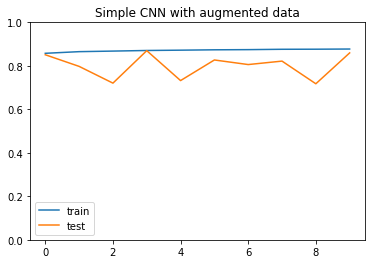

In [0]:
plt.plot(history_aug.history['acc'], label='train')
plt.plot(history_aug.history['val_acc'], label='test')
plt.title("Simple CNN with augmented data")
plt.legend()
plt.ylim(0,1)
plt.show()

In [0]:
print('Training Accuracy: {}'.format(np.round(history_aug.history['acc'][-1], 2)))
print('Validation Accuracy: {}'.format(np.round(history_aug.history['val_acc'][-1], 2)))

Training Accuracy: 0.88
Validation Accuracy: 0.86


At the expense of a much increased training time, we can see that the same model with augmented data does a little bit better in terms of validation accuracy. The plot also show us that the validation accuracy fluctuates less and generally stays higher. The final accuracy numbers tell us that we indeed overfit less, as the training accuracy has decreased and the validation accuracy is much increased.

#### 3.3 Deeper model

Here is our deeper model with residual connections. The architecture is inspired by resnet.

In [0]:
inputs = Input(shape = (50, 50, 3))

                                                             ### First layer ###
x1 = Conv2D(32, (3, 3), activation='relu')(inputs)           # Conv Layer
x2 = BatchNormalization()(x1)                                # Batch Norm.
x4 = MaxPooling2D(pool_size=(2, 2))(x2)                      # Pooling Layer
                                                          
                         
x5 = Conv2D(32, (3, 3), padding='same', 
            activation='relu')(x4)                           # Conv Layer
x6 = BatchNormalization()(x5)                                # Batch Norm.

x8 = Conv2D(32, (3, 3), padding='same', 
            activation='relu')(x6)                           # Conv Layer
x9 = BatchNormalization()(x8)                                # Batch Norm.

x11 = add([x4, x9])                                          # Residual connection

x12 = Conv2D(32, (3, 3), padding='same', 
             activation='relu')(x11)                         # Conv Layer
x13 = BatchNormalization()(x12)                              # Batch Norm.

x15 = Conv2D(32, (3, 3), padding='same', 
             activation='relu')(x13)                         # Conv Layer
x16 = BatchNormalization()(x15)                              # Batch Norm.           

x80 = add([x11, x16])                                        # Residual connection

x99 = Conv2D(32, (3, 3), padding='same', 
             activation='relu')(x80)                         # Conv Layer
x98 = BatchNormalization()(x99)                              # Batch Norm.

x97 = Conv2D(32, (3, 3), padding='same', 
             activation='relu')(x98)                         # Conv Layer
x96 = BatchNormalization()(x97)                              # Batch Norm.           

x18 = add([x80, x96])                                        # Residual connection

x19 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x18)                         # Conv Layer
x20 = BatchNormalization()(x19)                              # Batch Norm.

x22 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x20)                         # Conv Layer
x23 = BatchNormalization()(x22)                              # Batch Norm.

x26 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x23)                         # Conv Layer
x27 = BatchNormalization()(x26)                              # Batch Norm.

x28 = add([x27, x20])                                        # Residual connection

x29 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x28)                         # Conv Layer
x30 = BatchNormalization()(x29)                              # Batch Norm.

x31 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x30)                         # Conv Layer
x32 = BatchNormalization()(x31)                              # Batch Norm.

x40 = add([x32, x28])                                        # Residual connection

x41 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x40)                         # Conv Layer
x42 = BatchNormalization()(x41)                              # Batch Norm.

x43 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x42)                         # Conv Layer
x44 = BatchNormalization()(x43)                              # Batch Norm.

x45 = add([x44, x40])                                        # Residual connection

x46 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x45)                         # Conv Layer
x47 = BatchNormalization()(x46)                              # Batch Norm.

x48 = Conv2D(64, (3, 3), padding='same', 
             activation='relu')(x47)                         # Conv Layer
x49 = BatchNormalization()(x48)                              # Batch Norm.

x33 = add([x45, x49])                                        # Residual connection

                                                             ### Last layer ###
x34 = Flatten()(x33)                                         # Flatten the data
x35 = Dense(64, activation='relu')(x34)                      # 64 units dense

preds = Dense(2, activation='softmax')(x35)                  ### Output ###

deep_res = Model(inputs=inputs, outputs=preds)
deep_res.compile(optimizer='adam', loss='categorical_crossentropy', 
             metrics=['accuracy'])

And here is the same model without residual connections.

In [0]:
input_shape = (50, 50, 3)
deep_nores = Sequential()

                                                             ### Layer 1 ###
deep_nores.add(Conv2D(32, (3, 3), activation='relu',         # Convolutional L
                 input_shape=input_shape, padding='same'))
deep_nores.add(BatchNormalization())                         # Batch Norm.
deep_nores.add(MaxPooling2D(pool_size=(2, 2)))               # Pooling Layer

for i in range(6):                                           ### Layers 2-7 ###
  deep_nores.add(Conv2D(32, (3, 3), activation='relu',
                       padding='same'))                      # Conv. Layer
  deep_nores.add(BatchNormalization())                       # Batch Norm.
  
for i in range(9):                                           ### Layers 8-16 ###
  deep_nores.add(Conv2D(32, (3, 3), activation='relu',
                       padding='same'))                      # Conv. Layer
  deep_nores.add(BatchNormalization())                       # Batch Norm.

                                                             ### Layer 17 ###
deep_nores.add(Flatten())                                    # Flatten the data
deep_nores.add(Dense(64, activation='relu'))                 # 64 units dense

deep_nores.add(Dense(2, activation='softmax'))               ### Output ###

deep_nores.compile(optimizer='adam', loss='categorical_crossentropy', 
                   metrics=['accuracy'])

Let's now train them.

In [0]:
history_res = deep_res.fit(X, y, batch_size=128, epochs=10, verbose=1,
                            validation_split=0.1)

Train on 141814 samples, validate on 15758 samples
Epoch 1/10
141814/141814 [==============================] - 110s 779us/step - loss: 0.4136 - acc: 0.8314 - val_loss: 0.4475 - val_acc: 0.8035
Epoch 2/10
141814/141814 [==============================] - 103s 726us/step - loss: 0.3477 - acc: 0.8540 - val_loss: 0.5230 - val_acc: 0.6894
Epoch 3/10
141814/141814 [==============================] - 103s 726us/step - loss: 0.3315 - acc: 0.8606 - val_loss: 0.5062 - val_acc: 0.7763
Epoch 4/10
141814/141814 [==============================] - 103s 724us/step - loss: 0.3180 - acc: 0.8671 - val_loss: 0.5878 - val_acc: 0.7549
Epoch 5/10
141814/141814 [==============================] - 103s 725us/step - loss: 0.3100 - acc: 0.8710 - val_loss: 0.3904 - val_acc: 0.8346
Epoch 6/10
141814/141814 [==============================] - 103s 724us/step - loss: 0.2989 - acc: 0.8752 - val_loss: 0.9218 - val_acc: 0.6654
Epoch 7/10
141814/141814 [==============================] - 103s 725us/step - loss: 0.2867 - acc:

In [0]:
history_nores = deep_nores.fit(X, y, batch_size=128, epochs=10, verbose=1,
                               validation_split=0.1)

Train on 141814 samples, validate on 15758 samples
Epoch 1/10
141814/141814 [==============================] - 78s 549us/step - loss: 0.4050 - acc: 0.8263 - val_loss: 0.8116 - val_acc: 0.5982
Epoch 2/10
141814/141814 [==============================] - 71s 497us/step - loss: 0.3597 - acc: 0.8471 - val_loss: 0.8282 - val_acc: 0.7086
Epoch 3/10
141814/141814 [==============================] - 70s 496us/step - loss: 0.3447 - acc: 0.8542 - val_loss: 2.5615 - val_acc: 0.6171
Epoch 4/10
141814/141814 [==============================] - 71s 499us/step - loss: 0.3364 - acc: 0.8586 - val_loss: 0.7981 - val_acc: 0.7068
Epoch 5/10
141814/141814 [==============================] - 71s 499us/step - loss: 0.3318 - acc: 0.8614 - val_loss: 1.1259 - val_acc: 0.7180
Epoch 6/10
141814/141814 [==============================] - 70s 497us/step - loss: 0.3253 - acc: 0.8638 - val_loss: 1.7328 - val_acc: 0.5802
Epoch 7/10
141814/141814 [==============================] - 71s 498us/step - loss: 0.3199 - acc: 0.8669

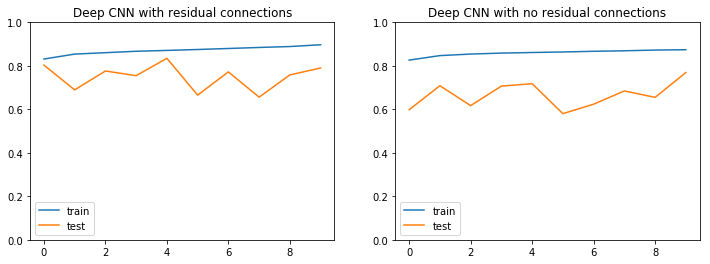

In [0]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(history_res.history['acc'], label='train')
ax[0].plot(history_res.history['val_acc'], label='test')
ax[0].set_title("Deep CNN with residual connections")
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(history_nores.history['acc'], label='train')
ax[1].plot(history_nores.history['val_acc'], label='test')
ax[1].set_title("Deep CNN with no residual connections")
ax[1].set_ylim(0,1)
ax[1].legend()
plt.show()

As we can see, removing the residual connections makes the performance decrease - although not by much. We expect the difference in performance to be even higher with an even deeper model.